In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [2]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
sample = pd.read_csv("sample_submission.csv")

In [3]:
df = pd.concat([train,test], sort=False) # Train and test data was combined for data preprocessing.
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


## EDA

In [4]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [5]:
def check_df(df):
    print("************** Shape **************")
    print(df.shape)    
    print("************** Types **************")
    print(df.dtypes)
    print("************** Head **************")
    print(df.head(5))
    print("************** Tail **************")
    print(df.tail(5))
    print("************** NA **************")
    print(df.isnull().sum())
    print("************** Quantiles **************")
    print(df.quantile(q=[0,0.05,0.25,0.5,0.75,0.95,0.99,1]).T)

In [6]:
check_df(train)

************** Shape **************
(913000, 4)
************** Types **************
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
************** Head **************
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
************** Tail **************
             date  store  item  sales
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
************** NA **************
date     0
store    0
item     0
sales    0
dtype: int64
************** Quantiles **************
       0.00  0.05  0.25  0.50  0.75   0.95   0.99   1.00
store   1.0   1.0   3.0   5.5   8.0   10.0   10.0   10.0
item    1.0   3.0  13.0  25.5  38.0   48.0   50.0   50.0
sales   0

In [7]:
check_df(test)

************** Shape **************
(45000, 4)
************** Types **************
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object
************** Head **************
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1
************** Tail **************
          id       date  store  item
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50
************** NA **************
id       0
date     0
store    0
item     0
dtype: int64
************** Quantiles **************
       0.00     0.05      0.25     0.50      0.75      0.95      0.99     1.00
id      0.0  2249.95  11249.75  22499.5  33749.25  42749.05  44549.01  44999.0
store   1.0     1.00      3.00      5.5      8.

In [8]:
check_df(df)

************** Shape **************
(958000, 5)
************** Types **************
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
************** Head **************
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
************** Tail **************
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
************** NA **************
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
************** Quantiles **************
       0.00     0.05      0.25     0.50      0.7

In [9]:
# How many items are in data?
df[["item"]].nunique()

item    50
dtype: int64

In [10]:
# How many items are in each store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [12]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

## Feature Engineering

### Date Features

In [13]:
def create_date_features(df):
    df["month"] = df.date.dt.month
    df["day_of_month"] = df.date.dt.day
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.weekofyear
    df["day_of_week"] = df.date.dt.dayofweek
    df["year"] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["is_month_start"] = df.date.dt.is_month_start.astype(int)
    df["is_month_end"] = df.date.dt.is_month_end.astype(int)
    return df

In [14]:
df = create_date_features(df)

<ipython-input-13-7b4448989484>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week_of_year"] = df.date.dt.weekofyear


In [15]:
df.head(10)

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
5,2013-01-06,1,1,12.0,NaN,1,6,6,1,6,2013,1,0,0
6,2013-01-07,1,1,10.0,NaN,1,7,7,2,0,2013,0,0,0
7,2013-01-08,1,1,9.0,NaN,1,8,8,2,1,2013,0,0,0
8,2013-01-09,1,1,12.0,NaN,1,9,9,2,2,2013,0,0,0
9,2013-01-10,1,1,9.0,NaN,1,10,10,2,3,2013,0,0,0


In [16]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

### Random Noise

In [17]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe)))

# when we derive new features we wil add random noise on these features.
# The reason we added random noise is related to the generalizability of the model.

### Lag/Shifted Features

In [18]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby(["store", "item"])["sales"].transform(
        lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [19]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 456, 546, 638, 728])

In [20]:
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_638,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,...,65.306887,68.761766,66.325215,85.181516,77.616496,59.995806,61.325119,99.021438,69.452934,69.002769
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,...,68.294043,57.818684,75.160982,83.714370,81.167890,70.807652,58.357052,79.198409,86.359438,68.924201
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,...,73.072488,65.109388,73.879259,88.065389,77.372641,67.859802,38.889059,98.074678,77.933497,77.502956
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,...,69.355222,66.813075,65.091390,78.695098,92.087523,69.147266,70.600760,76.126060,88.300867,80.894258


### Rolling Mean Features

In [21]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(["store", "item"])["sales"].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df, [90, 180, 270, 365, 546, 636, 706])

In [22]:
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_546,sales_lag_638,sales_lag_728,sales_roll_mean_90,sales_roll_mean_180,sales_roll_mean_270,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_636,sales_roll_mean_706
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,...,99.021438,69.452934,69.002769,NaN,71.536961,83.042040,85.695935,84.931855,84.579902,81.335550
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,...,79.198409,86.359438,68.924201,NaN,73.751912,80.557328,87.714213,84.657490,82.640232,84.526869
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,...,98.074678,77.933497,77.502956,NaN,74.866286,80.716748,89.965095,83.894471,81.814460,82.408168
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,...,76.126060,88.300867,80.894258,NaN,71.573538,82.790095,85.219180,85.344822,83.777886,84.207982


### Exponentially Weighted Mean Features

In [23]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales_ewm_alpha_" + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
            dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [24]:
alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1]
lags = [91, 98, 105, 112, 150, 180, 270, 330, 365, 450, 546, 728]

In [25]:
df = ewm_features(df, alphas, lags)

In [26]:
check_df(df)

************** Shape **************
(958000, 153)
************** Types **************
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_01_lag_330           float64
sales_ewm_alpha_01_lag_365           float64
sales_ewm_alpha_01_lag_450           float64
sales_ewm_alpha_01_lag_546           float64
sales_ewm_alpha_01_lag_728           float64
Length: 153, dtype: object
************** Head **************
        date  store  item  sales  id  month  day_of_month  day_of_year  \
0 2013-01-01      1     1   13.0 NaN      1             1            1   
1 2013-01-02      1     1   11.0 NaN      1             2            2   
2 2013-01-03      1     1   14.0 NaN      1             3            3   
3 2013-01-04      1     1   13.0 NaN      1             4    

### One-Hot Encoding

In [27]:
df = pd.get_dummies(df, columns=["store", "item", "day_of_week", "month"], drop_first= True)

In [28]:
df

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,2013,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,2,1,2013,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,3,1,2013,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,4,1,2013,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0,NaN,5,5,1,2013,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,NaN,44995.0,27,86,13,2018,0,0,0,...,1,0,0,0,0,0,0,0,0,0
44996,2018-03-28,NaN,44996.0,28,87,13,2018,0,0,0,...,1,0,0,0,0,0,0,0,0,0
44997,2018-03-29,NaN,44997.0,29,88,13,2018,0,0,0,...,1,0,0,0,0,0,0,0,0,0
44998,2018-03-30,NaN,44998.0,30,89,13,2018,1,0,0,...,1,0,0,0,0,0,0,0,0,0


### Converting Sales to log(1+sales)

In [29]:
df["sales"] = np.log1p(df["sales"].values)
check_df(df)

************** Shape **************
(958000, 224)
************** Types **************
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 224, dtype: object
************** Head **************
        date     sales  id  day_of_month  day_of_year  week_of_year  year  \
0 2013-01-01  2.639057 NaN             1            1             1  2013   
1 2013-01-02  2.484907 NaN             2            2             1  2013   
2 2013-01-03  2.708050 NaN             3            3             1  2013   
3 2013-01-04  2.639057 NaN             4            4             1  2013   
4 2013-01-05  2.397895 NaN             5            5             1  2013   

   is_wknd  is_month_start  is_month_end  ...  m

### Model

#### Custom Cost Function

- MAE: Mean Absolute Error
- MAPE: Mean Absolute Percentage Error
- SMAPE: Symmetric Mean Absolute Percentage Error (adjusted MAPE)

In [30]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [31]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

#### Time-Based Validation Sets

In [32]:
# # The data is divided into train and validation set.

train_v = df.loc[(df["date"] < "2017-01-01")]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [33]:
cols = [col for col in train_v.columns if col not in ["date", "id", "sales", "year"]]

In [34]:
Y_train = train_v["sales"]
X_train = train_v[cols]

Y_val = val["sales"]
X_val = val[cols]

In [35]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 220), (45000,), (45000, 220))

### LightGBM parameters

In [36]:
lgb_params = {"metric": {"mae"},
              "num_leaves": 10,
              "learning_rate": 0.02,
              "feature_fractions": 0.8,
              "max_depth": 5,
              "verbose": 0,
              "num_boost_round": 1000,
              "early_stopping_rounds": 200,
              "nthread": -1}

In [37]:
# Lightgbm divides the data into train and test in order for the model to run faster.

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [38]:
model = lgb.train(lgb_params, lgbtrain,
                 valid_sets = [lgbtrain, lgbval],
                 num_boost_round = lgb_params["num_boost_round"],
                 early_stopping_rounds = lgb_params["early_stopping_rounds"],
                 feval = lgbm_smape,
                 verbose_eval = 100)

C:\Users\burak.turkay\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\burak.turkay\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: feature_fractions
[LightGBM] [Warning] Unknown parameter: feature_fractions
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.726660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: feature_fractions
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.170041	training's SMAPE: 17.3486	valid_1's l1: 0.169747	valid_1's SMAPE: 17.3552
[200]	training's l1: 0.14089	training's SMAPE: 14.4323	valid_1's l1: 0.143389	valid_1's SMAPE: 14.7145
[300]	training's l1: 0.134648	training's SMAPE: 13.8065	valid_1's l1: 0.13822	valid_1's SMAPE: 14.1947
[400]	training's l1: 0.132414	training's SMAPE: 13.5832	valid_1's l1: 0.136342	valid_1's SMAPE: 14.0062
[500]	training's l1: 0.13105	training's SMAPE: 13.4468	valid_1's l1: 0.1351	valid_1's SMAPE: 13.8814
[600]	training's l1: 0.130146	training's SMAPE: 13.3564	valid_1's l1: 0.134335	valid

In [39]:
y_pred_val = model.predict(X_val, num_iteration = model.best_iteration)

In [40]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.625762587289332

### Importance Level of Features

In [41]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                            'split': model.feature_importance('split'),
                            'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10,10))
        sns.set(font_scale=1)
        sns.barplot(x='gain', y='feature', data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model, num=30)

                         feature  split       gain
18            sales_roll_mean_90    770  68.772055
13                 sales_lag_364   1322   9.164434
24           sales_roll_mean_706    166   4.886491
23           sales_roll_mean_636    160   4.219422
140   sales_ewm_alpha_01_lag_330    419   3.587499
3                        is_wknd    456   2.228129
1                    day_of_year    776   1.397223
141   sales_ewm_alpha_01_lag_365    472   0.913338
219                     month_12    240   0.546449
36   sales_ewm_alpha_099_lag_728     67   0.518783
22           sales_roll_mean_546    132   0.421348
203                day_of_week_1    172   0.317771
205                day_of_week_3    232   0.304602
129   sales_ewm_alpha_02_lag_365    131   0.295575
12                 sales_lag_182     81   0.235361
218                     month_11    119   0.186827
208                day_of_week_6    105   0.173030
204                day_of_week_2    175   0.167993
2                   week_of_yea

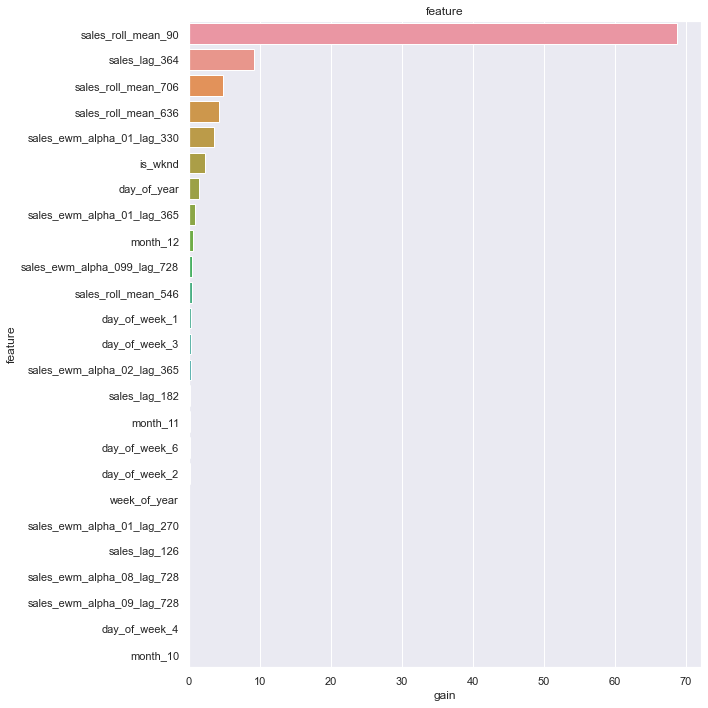

In [42]:
plot_lgb_importances(model, num=30, plot=True)

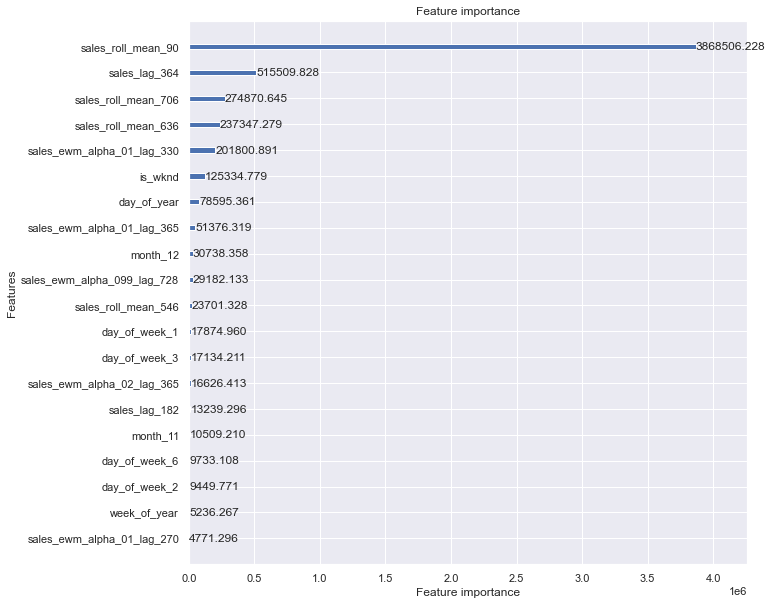

In [43]:
lgb.plot_importance(model, max_num_features = 20, figsize=(10,10), importance_type="gain")
plt.show()

## Final Model 

In [44]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

In [45]:
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [46]:
lgb_params = {"metric": {"mae"},
              "num_leaves": 10,
              "learning_rate": 0.02,
              "feature_fractions": 0.8,
              "max_depth": 5,
              "verbose": 0,
              "nthread": -1,
              "num_boost_round": model.best_iteration}

### LightGBM dataset

In [47]:
lgbtrain_all = lgb.Dataset(data = X_train, label = Y_train, feature_name = cols)

In [48]:
model = lgb.train(lgb_params, lgbtrain_all, num_boost_round = model.best_iteration)

C:\Users\burak.turkay\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: feature_fractions
[LightGBM] [Warning] Unknown parameter: feature_fractions
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.929541 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [49]:
test_preds = model.predict(X_test, num_iteration = model.best_iteration)

In [50]:
submission_df = test.loc[:, ['id', 'sales']]

In [51]:
submission_df['sales'] = np.expm1(test_preds)

In [52]:
submission_df['id'] = submission_df['id'].astype('int')

In [53]:
submission_df.to_csv('submission_demand.csv', index=False)

In [54]:
submission_df.head

<bound method NDFrame.head of           id      sales
0          0  12.901526
1          1  15.123840
2          2  14.559720
3          3  15.262590
4          4  17.198354
...      ...        ...
44995  44995  43.216641
44996  44996  41.626081
44997  44997  44.363592
44998  44998  47.219874
44999  44999  44.467914

[45000 rows x 2 columns]>